In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy import interp
import statistics 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from statistics import mean 
import statsmodels.api as sms
from sklearn.utils import resample

from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import log_loss

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut 

from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier

from functools import reduce
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
import itertools
import copy

import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

np.random.seed(100)

In [194]:
import xgboost as xgb
xgb.__version__

'0.90'

In [195]:
df = pd.read_csv('Diabetes Data.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,Anemia,BMI,HDL,LDL,Pesticide Use,Age,Alcohol Use,Diabetes,Exercise,Fasting Glucose,...,Insulin_NaN,SysBP_NaN,DiaBP_NaN,Alcohol Use_NaN,Mexican American,Hispanic,White,Black,Asian,Other Race
0,0.0,-1.624450,1.814557,-0.288805,0.0,1.399115,-1.061516,0.0,1.0,0.377156,...,0,0,0,0,0,0,1,0,0,0
1,0.0,1.183858,0.284185,-0.416550,0.0,0.729447,-0.368968,0.0,1.0,0.574394,...,0,0,0,0,0,0,1,0,0,0
2,0.0,-1.482733,2.334568,-1.368495,0.0,-1.223751,-0.368968,0.0,1.0,-0.942001,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0.185727,-1.582470,0.282361,0.0,-0.888917,5.863966,0.0,0.0,0.173088,...,0,0,0,0,1,0,0,0,0,0
4,0.0,1.210246,0.082563,1.553668,0.0,-0.554083,-0.715242,0.0,0.0,0.104585,...,0,1,1,0,0,0,0,1,0,0


In [196]:
y = df['Diabetes']
X = df.drop(['Diabetes'],axis = 1)
X_names = df.drop(['Diabetes'],axis = 1).columns.tolist()
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = 2)


In [197]:
numerical_variables = ['BMI','HDL','LDL','Age','Alcohol Use','Fasting Glucose','Insulin','sysBP','diaBP',
                       'Leg Length','Waist Size']
categorical_variables = ['Mexican American','Hispanic','White','Black','Asian','Other Race',
                          'BMI_NaN','Fasting glucose_NaN','LDL_NaN','HDL_NaN','Insulin_NaN',
                          'SysBP_NaN','DiaBP_NaN','Alcohol Use_NaN',
                         'Gender', 'Exercise', 'Pesticide Use','Anemia']
feature_list = numerical_variables + categorical_variables
len(feature_list)


29

In [198]:
def plot_confusion_matrix(y_val, y_val_predictions):
    cm = metrics.confusion_matrix(y_val, y_val_predictions)

    class_names=[0,1] 
    plt.figure(figsize=(5,3))
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [199]:
# Create a series with feature importances:
def feature_importance(clf,X_names):
    featimp = pd.Series(clf.feature_importances_,index=X_names).sort_values(ascending=False)
    print('feature importance')
    print(featimp)
    plt.figure(figsize=(10,5))
    sns.set(font_scale=0.9)
    sns.barplot(x=featimp, y=featimp.index,dodge=False)
    plt.xlabel('Feature Importance Score',fontsize = 13)
    plt.ylabel('Features',fontsize = 13)
    plt.title("Feature Importance",fontsize = 13)
    plt.show()
    return featimp


In [200]:
##### RUN THIS CELL WILL CLEAR OUT model_results!!!!!!!! #####
model_results = pd.DataFrame(columns=['Name', 'Accuracy', 'Recall', 'Precision', 'F1','Roc Auc'])

In [201]:
best_clf_probabilities = {}

def add_results(clf_name,accuracy,recall,precision,f1,roc_auc):
    global model_results        
    new_row = pd.DataFrame([[clf_name, accuracy, recall, precision, f1, roc_auc]], columns=model_results.columns)
    model_results = model_results.append(new_row, ignore_index=True)
    model_results = model_results.sort_values(by=['Name'])

    
def fit_and_predict(clf, clf_name, X_train, y_train, X_val, y_val):    
    
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    
    add_results(clf_name,accuracy,recall,precision,f1,roc_auc)
    
    if 'Best' in clf_name:
#         plot_roc(y_val,y_val_pred,clf,X_val)
        plot_confusion_matrix(y_val, y_val_pred)
        probability = clf.predict_proba(X_val)[:, 1]
        best_clf_probabilities[clf_name] = probability
    
    return clf


In [202]:
def hyperparameters(clf, method, grid):
    
    if method == 'random':
        clf_search = RandomizedSearchCV(clf, param_distributions = grid,scoring = 'roc_auc', verbose=2, random_state=42, n_jobs = -1)
    elif method == 'gridsearch':
        clf_search = GridSearchCV(clf, param_grid = grid, n_jobs = -1,scoring = 'roc_auc', refit = True)
    else: 
        print('not included')
    
    return clf_search


### steps:
1. A search through all candidate models, and pick the best ones to tune
2. For the good baseline models selected from step 1, do feature selection
3. Based on the result of step 2, do hyperparameter tuning

In [203]:
# step 1:
# Compare baseline models

clf_list = [
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('SVC', SVC(random_state=0)),
    ('Logistic Regression', LogisticRegression(random_state=0)),
    ('KNN', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier(random_state=0)),
]

sm = SMOTE(random_state=42)

for clf_name, clf in clf_list:
    print(clf_name)
    baseline_pipeline = Pipeline([('sm', sm),
                                  ('clf', clf)])
    fit_and_predict(baseline_pipeline, clf_name, X_train.values, y_train.values, X_val.values, y_val.values)

Random Forest
SVC
Logistic Regression
KNN
XGBoost


In [204]:
model_results

,Name,Accuracy,Recall,Precision,F1,Roc Auc
0,KNN,0.817404,0.712121,0.301282,0.423423,0.770234
1,Logistic Regression,0.827389,0.803030,0.329193,0.466960,0.816476
2,Random Forest,0.925820,0.484848,0.640000,0.551724,0.728251
3,SVC,0.851641,0.742424,0.360294,0.485149,0.802708
4,XGBoost,0.915835,0.606061,0.547945,0.575540,0.777046


### baseline results

In [205]:
model_results = model_results.sort_values(by=['Roc Auc'],ascending=False)
model_results

,Name,Accuracy,Recall,Precision,F1,Roc Auc
1,Logistic Regression,0.827389,0.803030,0.329193,0.466960,0.816476
3,SVC,0.851641,0.742424,0.360294,0.485149,0.802708
4,XGBoost,0.915835,0.606061,0.547945,0.575540,0.777046
0,KNN,0.817404,0.712121,0.301282,0.423423,0.770234
2,Random Forest,0.925820,0.484848,0.640000,0.551724,0.728251


In [206]:
# clear baseline results
model_results = pd.DataFrame(columns=['Name', 'Accuracy', 'Recall', 'Precision', 'F1','Roc Auc'])

#### Attempt 1: random forest

In [207]:
sm = SMOTE(random_state=42)
rf = RandomForestClassifier(random_state=0,n_jobs=-1)

pipeline1 = Pipeline([('sm', sm), 
                      ('rf', rf)])

rf1 = fit_and_predict(pipeline1, 'rf: Baseline', X_train, y_train, X_val, y_val)

feature importance
Fasting Glucose        0.197765
Age                    0.174828
Exercise               0.094001
LDL                    0.057734
Waist Size             0.055642
sysBP                  0.042533
Leg Length             0.038202
diaBP                  0.037104
White                  0.035871
Alcohol Use            0.033960
HDL                    0.033939
Insulin                0.030791
BMI                    0.027935
Mexican American       0.021282
Gender                 0.018158
Alcohol Use_NaN        0.016488
Hispanic               0.013073
Black                  0.012896
Pesticide Use          0.011155
Anemia                 0.008799
Asian                  0.008153
DiaBP_NaN              0.006921
SysBP_NaN              0.006515
LDL_NaN                0.005776
Insulin_NaN            0.004997
Fasting glucose_NaN    0.002438
HDL_NaN                0.001438
BMI_NaN                0.000988
Other Race             0.000620
dtype: float64


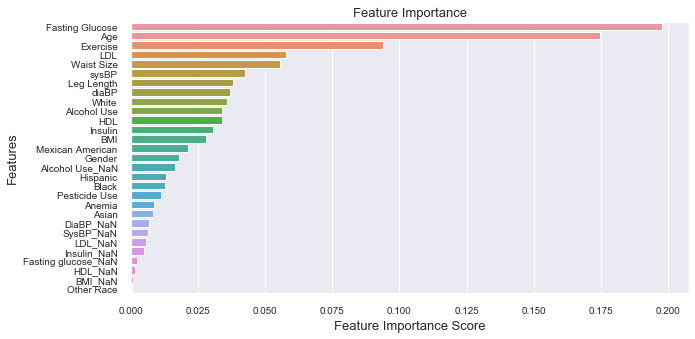

In [208]:
featimp = feature_importance(rf1[1],X_names)

In [209]:
# highest roc_auc at threshold = 0.04
# thresholds = [0,0.0001,0.001,0.005,0.01,0.02,0.03,0.035,0.04,0.05,0.1]
threshold = 0.04
sfm = SelectFromModel(RandomForestClassifier(random_state=0), threshold=threshold)
pipeline2 = Pipeline([('sm', sm), 
                      ('sfm', sfm),
                      ('rf', rf)])

rf2 = fit_and_predict(pipeline2, 'rf: Feature importance', X_train, y_train, X_val, y_val)

In [210]:
chosen_feature_indices = rf2[1].get_support(indices=True)
rf_features = [X_names[i] for i in chosen_feature_indices]
rf_features

['LDL', 'Age', 'Exercise', 'Fasting Glucose', 'Waist Size', 'sysBP']

In [211]:
# grid 1
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 105, num = 10)]
max_features = ['sqrt','log2',None]
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
min_samples_split = [10,20,30,40,50]
min_samples_leaf = [10,20,30,40,50] 
bootstrap = [True]

rf_grid =  {'rf__bootstrap': bootstrap,
            'rf__max_depth': max_depth,
            'rf__max_features': max_features,
            'rf__min_samples_leaf': min_samples_leaf,
            'rf__min_samples_split': min_samples_split,
            'rf__n_estimators': n_estimators}

In [212]:
rf4 = hyperparameters(pipeline1,'random',rf_grid) 
rf4 = fit_and_predict(rf4, 'rf: Feature importance + random search 1', X_train[rf_features], y_train, X_val[rf_features], y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.3s finished


In [213]:
rf4.best_params_

{'rf__n_estimators': 27,
 'rf__min_samples_split': 50,
 'rf__min_samples_leaf': 20,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 27,
 'rf__bootstrap': True}

In [214]:
# random search on another grid2: with a wider range
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_split = [10,20,30,40,50]
min_samples_leaf = [10,20,30,40,50] 
bootstrap = [True]

rf_grid =  {'rf__bootstrap': bootstrap,
            'rf__max_depth': max_depth,
            'rf__max_features': max_features,
            'rf__min_samples_leaf': min_samples_leaf,
            'rf__min_samples_split': min_samples_split,
            'rf__n_estimators': n_estimators}

In [215]:
rf5 = hyperparameters(pipeline1,'random',rf_grid) 
rf5 = fit_and_predict(rf5, 'rf: Feature importance + random search 2', X_train[rf_features], y_train, X_val[rf_features], y_val)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.2s finished


In [216]:
def generate_parameter_score(clf,X_train):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()
    
def plot_parameter_scores(parameters,parameter_name,cross_val_results):
    plt.figure(figsize=(10,5))
    line = plt.plot(parameters,cross_val_results,'bo-')
    plt.ylabel('Roc Auc',fontsize=13)
    plt.xlabel(parameter_name,fontsize=13)
    plt.legend(['cross_val_score'],fontsize=13)
    plt.show()    

* See how roc auc scores changes as one parameter changes in a range

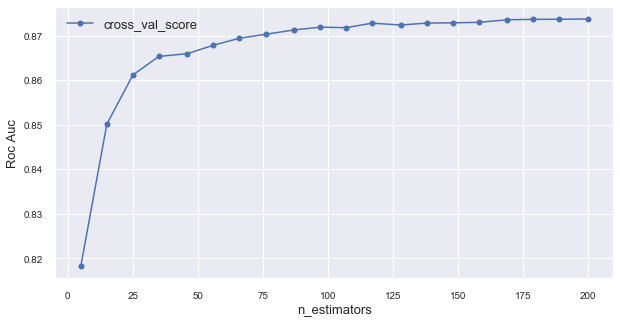

In [217]:
# n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 20)]
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 20)]

scores = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1,random_state=0)
    pipeline0 = Pipeline([('sm',sm),('rf',rf)])
    scores.append(generate_parameter_score(pipeline0,X_train[rf_features]))

plot_parameter_scores(n_estimators,'n_estimators',scores)

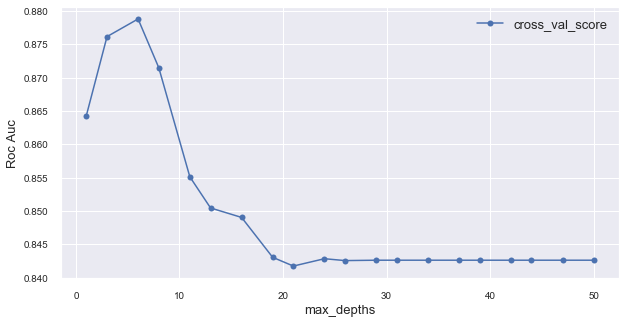

In [218]:
max_depths = [int(x) for x in np.linspace(start = 1, stop = 50, num = 20)]
# max_depths = [int(x) for x in np.linspace(10, 50, num = 10)]

scores = []
for depth in max_depths:
    rf = RandomForestClassifier(max_depth=depth, n_jobs=-1,random_state=0)
    pipeline0 = Pipeline([('sm',sm),('rf',rf)])
    scores.append(generate_parameter_score(pipeline0,X_train[rf_features]))

plot_parameter_scores(max_depths,'max_depths',scores)

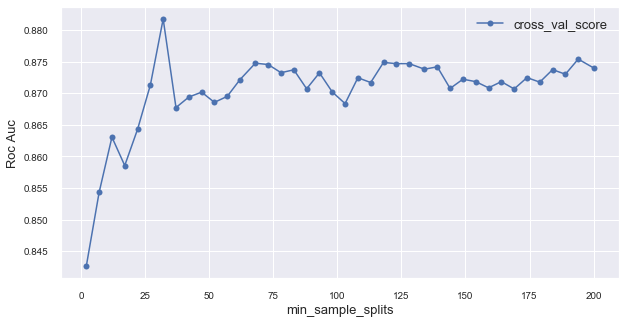

In [219]:
min_samples_splits = [int(x) for x in np.linspace(start = 2, stop = 200, num = 40)]
scores = []
for split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=split, n_jobs=-1,random_state=0)
    pipeline0 = Pipeline([('sm',sm),('rf',rf)])
    scores.append(generate_parameter_score(pipeline0,X_train[rf_features]))

plot_parameter_scores(min_samples_splits,'min_sample_splits',scores)

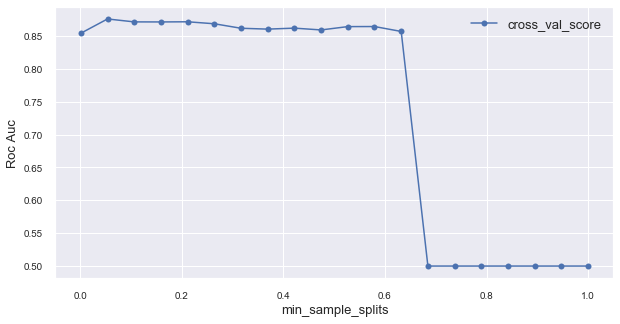

In [220]:
min_samples_splits = np.linspace(0.001, 1, 20, endpoint=True)
scores = []
for split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=split, n_jobs=-1,random_state=0)
    pipeline0 = Pipeline([('sm',sm),('rf',rf)])
    scores.append(generate_parameter_score(pipeline0,X_train[rf_features]))

plot_parameter_scores(min_samples_splits,'min_sample_splits',scores)

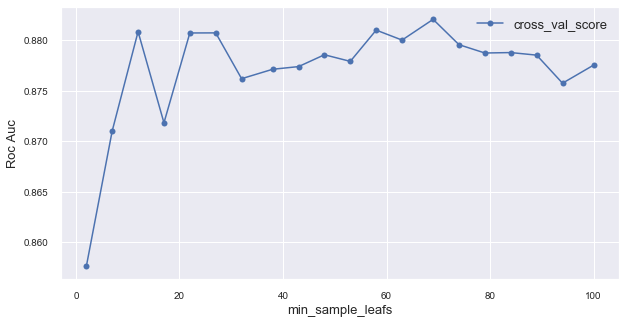

In [221]:
# min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
min_samples_leafs = [int(x) for x in np.linspace(start = 2, stop = 100, num = 20)] 
scores = []
for leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=leaf, n_jobs=-1,random_state=0)
    pipeline0 = Pipeline([('sm',sm),('rf',rf)])
    scores.append(generate_parameter_score(pipeline0,X_train[rf_features]))

plot_parameter_scores(min_samples_leafs,'min_sample_leafs',scores)

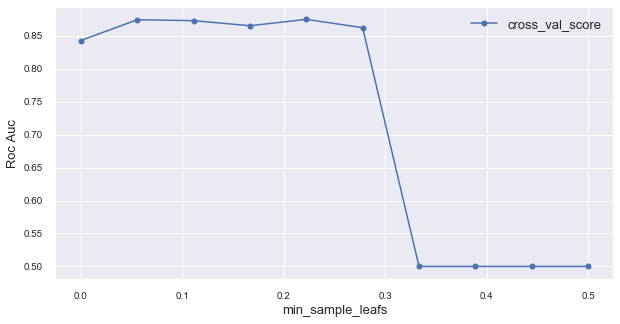

In [222]:
min_samples_leafs = np.linspace(0.0001, 0.5, 10, endpoint=True)
scores = []
for leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=leaf, n_jobs=-1,random_state=0)
    pipeline0 = Pipeline([('sm',sm),('rf',rf)])
    scores.append(generate_parameter_score(pipeline0,X_train[rf_features]))

plot_parameter_scores(min_samples_leafs,'min_sample_leafs',scores)

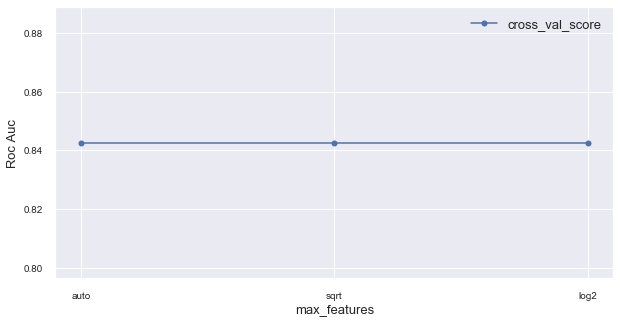

In [223]:
max_features = ['auto', 'sqrt','log2']
scores = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature, n_jobs=-1,random_state=0)
    pipeline0 = Pipeline([('sm',sm),('rf',rf)])
    scores.append(generate_parameter_score(pipeline0,X_train[rf_features]))

plot_parameter_scores(max_features,'max_features',scores)

In [224]:
best_rf = rf4.best_estimator_

<Figure size 360x216 with 0 Axes>

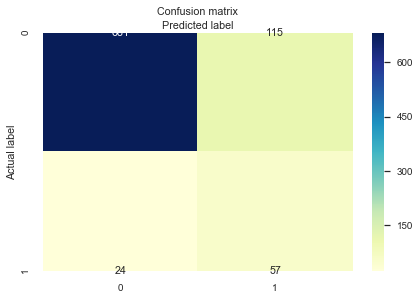

In [225]:
best_rf_test = fit_and_predict(best_rf, 'rf: Best on test', X_train[rf_features], y_train, X_test[rf_features], y_test)


In [226]:
baseline_rf_test = fit_and_predict(pipeline1, 'rf: Baseline on test', X_train, y_train, X_test, y_test)

In [227]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(best_clf,X):
    train_sizes = [int(x) for x in np.linspace(start = 100, stop = 2336, num = 30)]
    train_sizes, train_scores, validation_scores = learning_curve(estimator = best_clf, 
                                                                  X = X, 
                                                                  y = y_train_val, 
                                                                  train_sizes = train_sizes, 
                                                                  cv = 3, 
                                                                  scoring = 'roc_auc')
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training error',marker='o')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error',marker='o')
    plt.ylabel('Roc Auc', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning Curves', fontsize = 14, y = 1.03)
    plt.legend()
    plt.ylim(0.4,1)

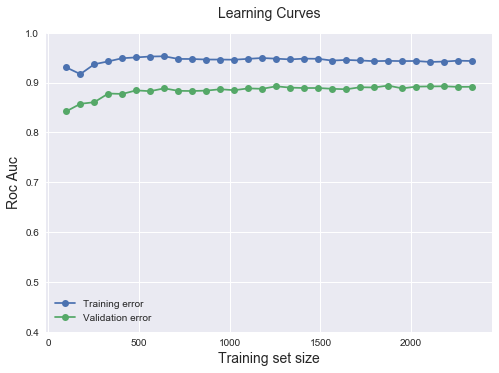

In [228]:
plot_learning_curve(best_rf[1],X_train_val[rf_features])

#### Attempt 2: XGBoost


In [229]:
xgb = XGBClassifier(random_state=0,n_jobs=-1)
pipeline1 = Pipeline([('sm', sm),('xgb1', xgb)])
xgb1 = fit_and_predict(pipeline1,'xgb: Baseline', X_train.values, y_train.values, X_val.values, y_val.values)

feature importance
Fasting Glucose        0.172057
Exercise               0.109651
Age                    0.072115
White                  0.070483
Alcohol Use_NaN        0.057501
Mexican American       0.056008
Gender                 0.054882
Black                  0.040792
Pesticide Use          0.040253
Hispanic               0.039256
Anemia                 0.037034
LDL                    0.033030
HDL_NaN                0.030908
Alcohol Use            0.025329
Insulin_NaN            0.018941
LDL_NaN                0.018779
HDL                    0.018198
diaBP                  0.017410
Asian                  0.016457
SysBP_NaN              0.014360
Insulin                0.010910
Other Race             0.010320
Waist Size             0.010238
sysBP                  0.009774
BMI                    0.007711
Leg Length             0.007606
BMI_NaN                0.000000
Fasting glucose_NaN    0.000000
DiaBP_NaN              0.000000
dtype: float32


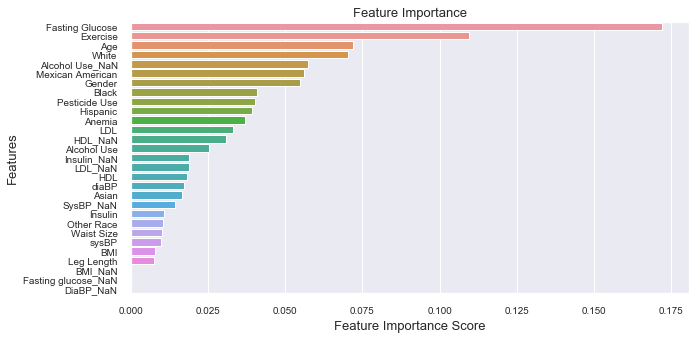

In [230]:
featimp = feature_importance(xgb1[1],X_names)

In [231]:
# highest roc_auc at threshold = 0.07
thresholds = [0,0.007,0.01,0.015,0.02,0.03,0.04,0.05,0.07]
threshold = 0.07
sfm = SelectFromModel(xgb, threshold=threshold)
pipeline0 = Pipeline([('sm', sm), 
                      ('sfm', sfm),
                      ('xgb', xgb)])

xgb2 = fit_and_predict(pipeline0, 'xgb: Feature importance', X_train, y_train, X_val, y_val)

In [232]:
chosen_feature_indices = xgb2[1].get_support(indices=True)
xgb_features = [X_names[i] for i in chosen_feature_indices]
xgb_features

['Age', 'Exercise', 'Fasting Glucose', 'White']

In [233]:
xgb_grid =  {'xgb1__min_child_weight': [int(x) for x in np.linspace(start = 1, stop = 100, num = 20)],
             'xgb1__gamma': [0.5, 1, 1.5, 2, 5],
             'xgb1__subsample': np.linspace(0.1, 1, 10, endpoint=True),
             'xgb1__colsample_bytree': np.linspace(0.1, 1, 10, endpoint=True),
             'xgb1__max_depth': [int(x) for x in np.linspace(start = 1, stop = 100, num = 20)]}


xgb5 = hyperparameters(pipeline1,'random',xgb_grid) 
xgb5 = fit_and_predict(xgb5, 'xgb: Feature importance + random search 1', X_train[xgb_features].values, y_train.values, X_val[xgb_features].values, y_val.values)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


In [234]:
xgb_grid =  {'xgb1__min_child_weight': [1, 5, 10],
             'xgb1__gamma': [0.5, 1, 1.5, 2, 5],
             'xgb1__subsample': [0.6, 0.8, 1.0],
             'xgb1__colsample_bytree': [0.6, 0.8, 1.0],
             'xgb1__max_depth': [3, 4, 5]}

xgb6 = hyperparameters(pipeline1,'random',xgb_grid) 
xgb6 = fit_and_predict(xgb6, 'xgb: Feature importance + random search 2', X_train[xgb_features].values, y_train.values, X_val[xgb_features].values, y_val.values)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


In [235]:
best_xgb = xgb5.best_estimator_

<Figure size 360x216 with 0 Axes>

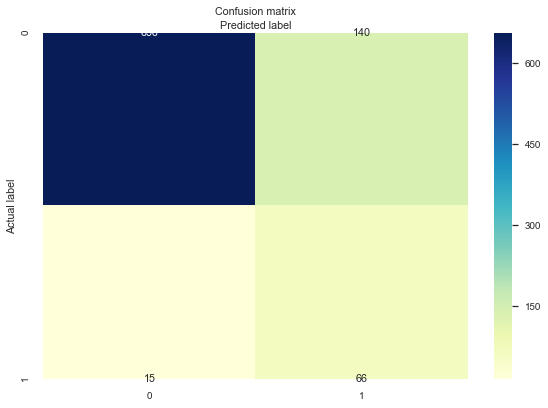

In [236]:
best_xgb_test = fit_and_predict(xgb5.best_estimator_, 'xgb: Best on test', X_train[xgb_features].values, y_train.values, X_test[xgb_features].values, y_test.values)


In [237]:
baseline_xgb_test = fit_and_predict(pipeline1, 'xgb: Baseline on test', X_train.values, y_train.values, X_test.values, y_test.values)


In [238]:
plot_learning_curve(best_xgb,X_train_val[xgb_features].values)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 6

In [ ]:
plot_learning_curve(best_xgb[1],X_train_val[xgb_features].values)

## FEATURE SELECTION

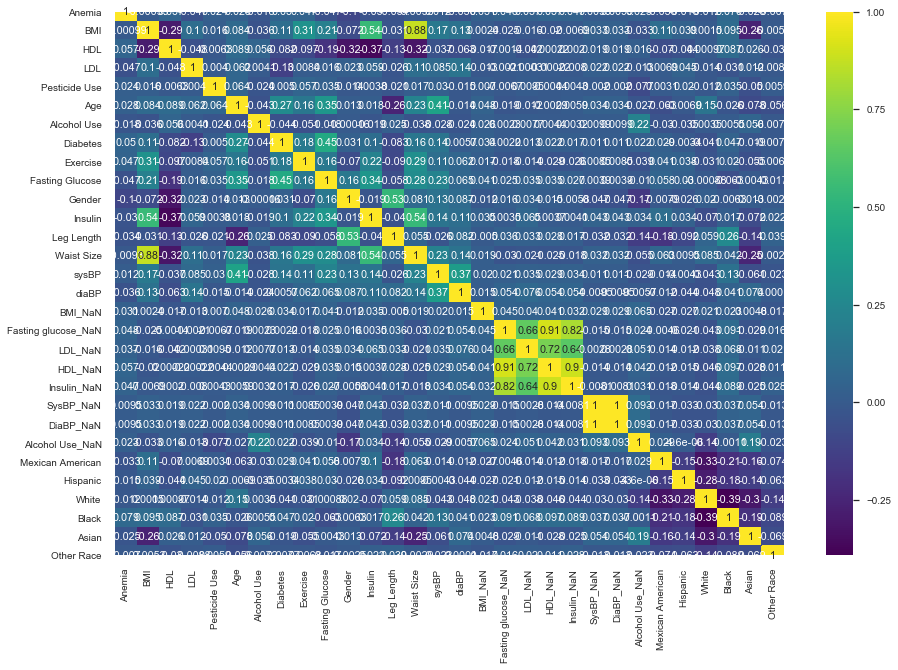

In [239]:
plt.figure(figsize=(15,10))
sns.heatmap(data= df.corr(), annot=True, cmap='viridis')

Text(0.5, 1.0, 'Feature correlation with diabetes')

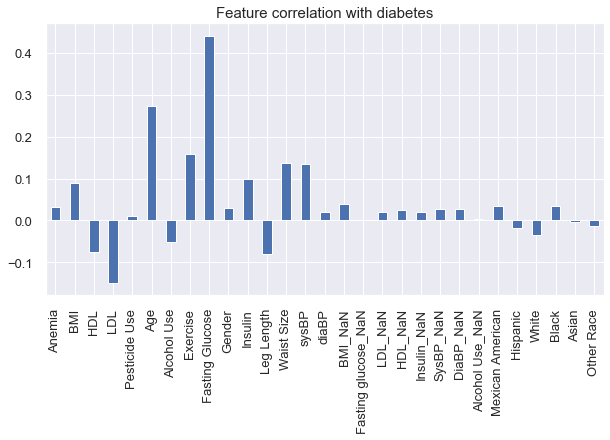

In [240]:
X_train.corrwith(y_train).plot.bar(figsize = (10, 5), fontsize = 13,grid = True)
plt.title('Feature correlation with diabetes',fontsize = 15)

### PCA

In [241]:
pca = PCA(0.9)
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(2804, 13)

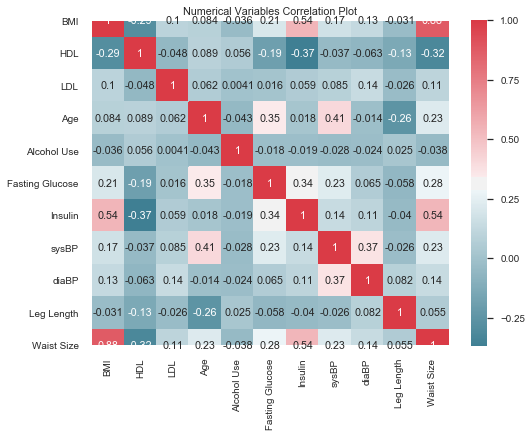

In [242]:
corr_df = df[numerical_variables]
cor = corr_df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Numerical Variables Correlation Plot")

sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

plt.show()

In [243]:
numerical_variables_1 = [v for v in numerical_variables if v!= 'BMI']

In [244]:
numerical_variables_1

['HDL',
 'LDL',
 'Age',
 'Alcohol Use',
 'Fasting Glucose',
 'Insulin',
 'sysBP',
 'diaBP',
 'Leg Length',
 'Waist Size']

### Kendall

relevant
Diabetes           1.000000
Fasting Glucose    0.271995
Age                0.225036
Waist Size         0.131785
sysBP              0.110581
LDL                0.104014
Name: Diabetes, dtype: float64

irrelevant
['HDL', 'Alcohol Use', 'Insulin', 'diaBP', 'Leg Length']

kendall pick these features:
['Fasting Glucose', 'Age', 'Waist Size', 'sysBP', 'LDL']


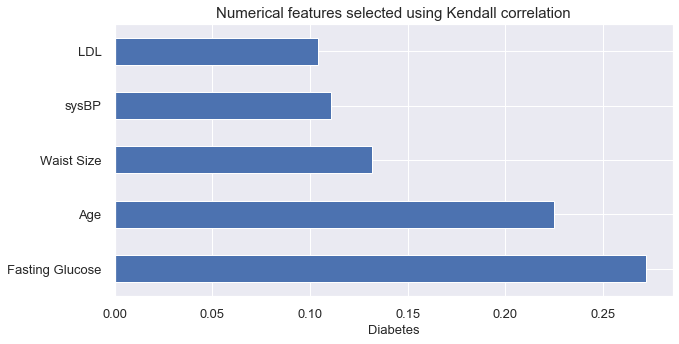

In [245]:
# kendall - filter method
# between numerical variables and y 

correlation_coefficient = 0.1
def feature_target_correlation(df,threshold):
    cor = df[numerical_variables_1+['Diabetes']].corr(method='kendall')
    cor_target = abs(cor['Diabetes'])
    irrelevant_features = cor_target[cor_target<threshold]
    relevant_features = cor_target[cor_target>threshold].sort_values(ascending=False)
    relevant_features[1:].plot(figsize = (10, 5),kind='barh',fontsize=13)
    plt.title('Numerical features selected using Kendall correlation',fontsize = 15)
    plt.xlabel('Diabetes',fontsize=13)
    print('relevant')
    print(relevant_features)
    print()
    print('irrelevant')
    print(list(irrelevant_features.index))

    return list(relevant_features.index)[1:]

kendall_features = feature_target_correlation(df,correlation_coefficient)
print()
print('kendall pick these features:')
print(kendall_features)

### CHI2

In [246]:
# Check relationship with y: chi-square test
def chi2():
    remove_list_chi = []
    chi_features = []
    for categorical_variable in categorical_variables:
        csq = chi2_contingency(pd.crosstab(y, df[categorical_variable]))
        p_value = csq[1]
        if p_value>0.05: 
            print(categorical_variable)
            print("P-value: ", p_value)
            remove_list_chi.append(categorical_variable)
        else: pass
    print(remove_list_chi)
    for v in categorical_variables:
        if v not in remove_list_chi:
            chi_features.append(v)
    return chi_features

In [247]:
chi_features = chi2()

Mexican American
P-value:  0.06691535191841347
Hispanic
P-value:  0.8867136521737536
Asian
P-value:  0.24529031953658043
Other Race
P-value:  0.7207394138461873
Fasting glucose_NaN
P-value:  0.9832368041720183
LDL_NaN
P-value:  0.45630005954196984
HDL_NaN
P-value:  0.17518283388635306
Insulin_NaN
P-value:  0.3022149103320376
SysBP_NaN
P-value:  0.5277624636971954
DiaBP_NaN
P-value:  0.5277624636971954
Alcohol Use_NaN
P-value:  0.16571702032611946
Pesticide Use
P-value:  0.8045789963264002
['Mexican American', 'Hispanic', 'Asian', 'Other Race', 'Fasting glucose_NaN', 'LDL_NaN', 'HDL_NaN', 'Insulin_NaN', 'SysBP_NaN', 'DiaBP_NaN', 'Alcohol Use_NaN', 'Pesticide Use']


In [248]:
print(chi_features)

['White', 'Black', 'BMI_NaN', 'Gender', 'Exercise', 'Anemia']


In [249]:
chi_kendall_features = chi_features + kendall_features
chi_kendall_features

['White',
 'Black',
 'BMI_NaN',
 'Gender',
 'Exercise',
 'Anemia',
 'Fasting Glucose',
 'Age',
 'Waist Size',
 'sysBP',
 'LDL']

### ANOVA

In [250]:
# ANOVA for numerical features, pick the top 5 features
k_best = SelectKBest(f_classif, k=5)
k_best.fit_transform(X_train[numerical_variables_1], y_train)
k_best.pvalues_
p_values = pd.DataFrame({'Feature': X_train[numerical_variables_1].columns, 'p_value':k_best.pvalues_}).sort_values('p_value')
p_values.head(5)

,Feature,p_value
4,Fasting Glucose,4.087135e-134
2,Age,6.178411e-49
1,LDL,1.952134e-15
9,Waist Size,3.412269e-13
6,sysBP,4.730123e-13


In [251]:
ANOVA_features = list(p_values['Feature'][:5])

In [252]:
chi_anova_features = chi_features + ANOVA_features
print(chi_anova_features)

['White', 'Black', 'BMI_NaN', 'Gender', 'Exercise', 'Anemia', 'Fasting Glucose', 'Age', 'LDL', 'Waist Size', 'sysBP']


### Backward Elimination

In [253]:
def backward_elimiation():
    cols = list(X_train.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X_train[cols]
        X_1 = sms.add_constant(X_1)
        model = sms.OLS(y_train,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols
    return selected_features_BE

be_features = backward_elimiation()

be_features

['Anemia',
 'HDL',
 'LDL',
 'Age',
 'Alcohol Use',
 'Exercise',
 'Fasting Glucose',
 'Gender',
 'Insulin',
 'Fasting glucose_NaN',
 'HDL_NaN',
 'Mexican American',
 'Black',
 'Asian']

### Random forest feature importance 

In [254]:
rf_features

['LDL', 'Age', 'Exercise', 'Fasting Glucose', 'Waist Size', 'sysBP']

### XGBoost feature importance 

In [255]:
xgb_features

['Age', 'Exercise', 'Fasting Glucose', 'White']

### VIF: check collinearity

In [256]:
# check for feature collinearity 
# When measuring, if the two features have a VIF of 1, then they are not collinear of each other 
# As the numbers increases, the higher they are correlated with each other. 
# If VIF returns a number greater than 5, then those two features should be reduced to one using PCA.

from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    Remaining_variables = X.columns[variables].tolist()
    return Remaining_variables

vif_features = calculate_vif(X_train)
print(vif_features)

dropping 'SysBP_NaN' at index: 20
dropping 'HDL_NaN' at index: 18
dropping 'Waist Size' at index: 12
['Anemia', 'BMI', 'HDL', 'LDL', 'Pesticide Use', 'Age', 'Alcohol Use', 'Exercise', 'Fasting Glucose', 'Gender', 'Insulin', 'Leg Length', 'sysBP', 'diaBP', 'BMI_NaN', 'Fasting glucose_NaN', 'LDL_NaN', 'Insulin_NaN', 'DiaBP_NaN', 'Alcohol Use_NaN', 'Mexican American', 'Hispanic', 'White', 'Black', 'Asian', 'Other Race']


### Recursive feature elimination: this needs to be done with model training

In [257]:
# This needs to be used with model training, not separately 
from sklearn.feature_selection import RFE

num_features = 15
    
def recursive_feature_elimination(rfe):
    chosen_vars = []
    for i in range(len(rfe.support_)):
        if rfe.support_[i] == True:
            chosen_vars.append(X_train.columns[i])
    print(len(chosen_vars), "features are chosen through RFE and they are", chosen_vars)
    return chosen_vars

In [258]:
feature_choices = {'chi_anova_features': chi_anova_features,
                   'chi_kendall_features': chi_kendall_features,
                   'be_features': be_features,
                   'rf_features': rf_features,
                   'vif_features': vif_features,
                   'xgb_features':xgb_features}

#### Attempt 3:  Logistic Regression
* A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression. 

In [259]:
# logreg: default L2
logreg = LogisticRegression(random_state=0,n_jobs=-1)
pipeline1 = Pipeline([('sm', sm), ('logreg', logreg)])

lr1 = fit_and_predict(pipeline1, 'lr: Baseline',X_train, y_train, X_val, y_val)

In [260]:
# lasso
logreg = LogisticRegression(penalty='l1',n_jobs =-1,solver='liblinear',random_state=0)
pipeline2 = Pipeline([('sm', sm), ('logreg', logreg)])
lr2 = fit_and_predict(pipeline2, 'lr: lasso',X_train, y_train, X_val, y_val)

In [261]:
# logreg with different feature selection
for name, features in feature_choices.items():
    lr = fit_and_predict(pipeline1, 'lr: '+' '+name,X_train[features],y_train, X_val[features], y_val)

In [262]:
# logreg feature selection cont.
# logreg + RFE: number of feature = 5 gives the best result
feature_num = 5
logreg = LogisticRegression(n_jobs=-1)
rfe_logreg = RFE(logreg,feature_num)
pipeline3 = Pipeline([('sm', sm), ('rfe_logreg', rfe_logreg)])
lr_rfe = fit_and_predict(pipeline3, 'lr: RFE '+str(feature_num), X_train,y_train, X_val, y_val)
lr_rfe_features = recursive_feature_elimination(lr_rfe[1])

5 features are chosen through RFE and they are ['Anemia', 'Age', 'Exercise', 'Fasting Glucose', 'Other Race']


In [263]:
# logreg + xgb features gives the best result
# use this for grid search
grid1 = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
lr3 = hyperparameters(pipeline1, 'gridsearch', grid1)
lr3 = fit_and_predict(lr3,'lr: xgb features + grid search 1',X_train[xgb_features], y_train, X_val[xgb_features], y_val)

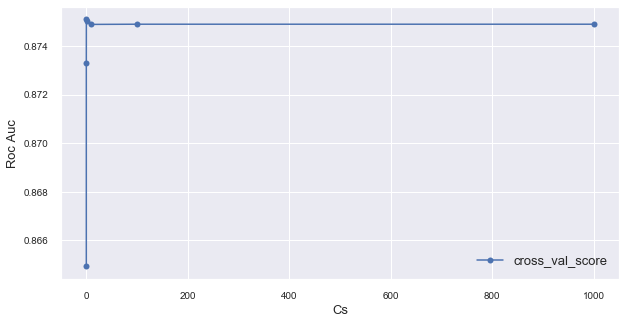

In [264]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
scores = []
for C in Cs:
    logreg = LogisticRegression(C=C,random_state=0,penalty='l2',n_jobs=-1)
    pipeline0 = Pipeline([('sm',sm),('logreg', logreg)])
    scores.append(generate_parameter_score(pipeline0,X_train[xgb_features]))

plot_parameter_scores(Cs,'Cs',scores)

In [265]:
best_lr = lr3.best_estimator_

In [266]:
lr3.best_params_

{'logreg__C': 1}

<Figure size 360x216 with 0 Axes>

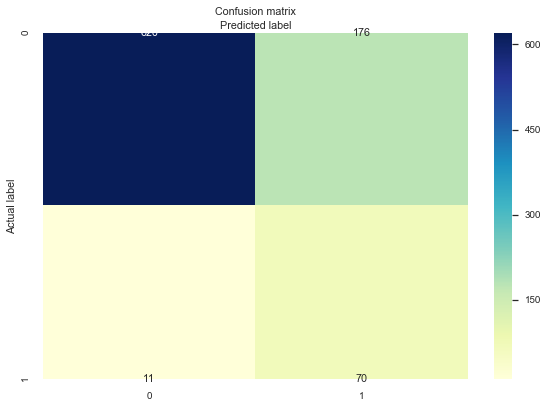

In [267]:
best_lr_on_test = fit_and_predict(best_lr,'lr: Best on test',X_train[xgb_features], y_train, X_test[xgb_features], y_test)

In [268]:
baseline_lr_test = fit_and_predict(pipeline1, 'lr: Baseline on test', X_train, y_train, X_test, y_test)

In [269]:
plot_learning_curve(best_lr,X_train_val[xgb_features])

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 6

#### Attempt 4: knn



In [270]:
knn = KNeighborsClassifier(n_jobs=-1)
pipeline1 = Pipeline([('sm', sm),('knn', knn)])
knn1 = fit_and_predict(pipeline1,'knn: Baseline', X_train, y_train, X_val, y_val)

In [271]:
# knn with different feature selection, knn has no RFE
for name, features in feature_choices.items():
    print(name)
    knn = fit_and_predict(pipeline1, 'knn: '+name,X_train[features],y_train, X_val[features], y_val)

chi_anova_features
chi_kendall_features
be_features
rf_features
vif_features
xgb_features


* small k: low bias, high variance; large k: high bias, low variance

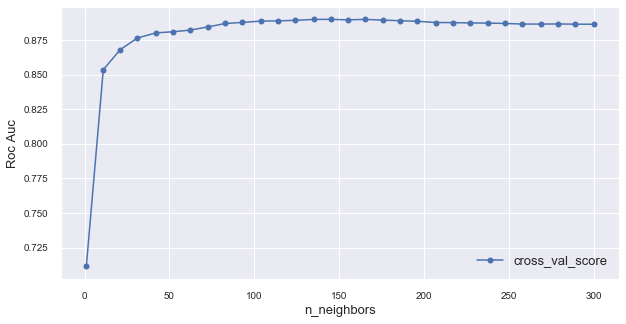

In [272]:
n_neighbors =  [int(x) for x in np.linspace(start = 1, stop = 300, num = 30)]
scores = []
for n_neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighbor,n_jobs=-1)
    pipeline0 = Pipeline([('sm',sm),('knn', knn)])
    scores.append(generate_parameter_score(pipeline0,X_train[chi_kendall_features]))

plot_parameter_scores(n_neighbors,'n_neighbors',scores)

In [273]:
# be_features are the best so far
knn_grid =  {'knn__metric': ['euclidean','manhattan'],
             'knn__weights': ['uniform','distance'],
             'knn__n_neighbors': [int(x) for x in np.linspace(start = 2, stop = 300, num = 20)]}

knn2 = hyperparameters(pipeline1, 'gridsearch', knn_grid)
knn2 = fit_and_predict(knn2,'knn: be_features + grid search 300',X_train[be_features], y_train, X_val[be_features], y_val)


In [274]:
knn2.best_params_

{'knn__metric': 'manhattan',
 'knn__n_neighbors': 300,
 'knn__weights': 'uniform'}

<Figure size 360x216 with 0 Axes>

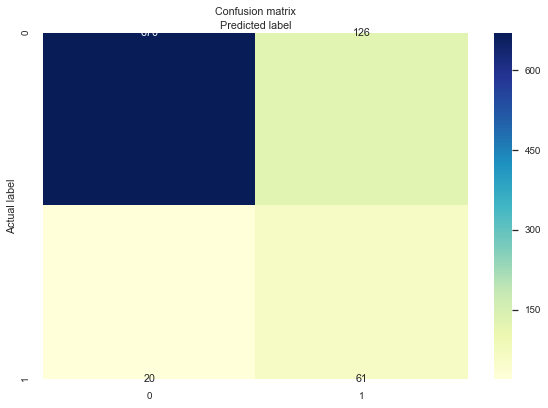

In [275]:
best_knn = knn2.best_estimator_
best_knn_on_test = fit_and_predict(best_knn,'knn: Best on test',X_train[be_features], y_train, X_test[be_features], y_test)

In [276]:
baseline_knn_test = fit_and_predict(pipeline1, 'knn: Baseline on test', X_train, y_train, X_test, y_test)

In [277]:
train_sizes = [int(x) for x in np.linspace(start = 300, stop = 2336, num = 30)]
train_sizes, train_scores, validation_scores = learning_curve(estimator = best_knn, 
                                                              X = X_train_val[be_features], 
                                                              y = y_train_val, 
                                                              train_sizes = train_sizes, 
                                                              cv = 3, 
                                                              scoring = 'roc_auc')
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error',marker='o')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error',marker='o')
plt.ylabel('Roc Auc', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning Curves', fontsize = 14, y = 1.03)
plt.legend()
plt.ylim(0.4,1)

KeyboardInterrupt: 

#### Attempt 5: SVM - SVC

In [278]:
svc = SVC(probability=True)
pipeline1 = Pipeline([('sm', sm),('svc', svc)])
svc1 = fit_and_predict(pipeline1,'svc: Baseline', X_train, y_train, X_val, y_val)

In [279]:
# svc feature selection
for name, features in feature_choices.items():
    print(name)
    svc = fit_and_predict(pipeline1, 'svc: '+name,X_train[features],y_train, X_val[features], y_val)

chi_anova_features
chi_kendall_features
be_features
rf_features
vif_features
xgb_features


In [280]:
# rfe SVC
# for num in [3,5,7,9,13,15]:
feature_num=9
svc = SVC(probability=True,kernel='linear')
rfe_svc = RFE(svc,feature_num)
pipeline0 = Pipeline([('sm', sm), ('rfe_svc', rfe_svc)])
svc_rfe = fit_and_predict(pipeline0, 'svc: RFE'+str(feature_num), X_train, y_train, X_val, y_val)
svc_rfe_features = recursive_feature_elimination(svc_rfe[1])

9 features are chosen through RFE and they are ['Anemia', 'LDL', 'Pesticide Use', 'Age', 'Exercise', 'Fasting Glucose', 'Hispanic', 'White', 'Other Race']


In [281]:
# SVC + xgb_features is the best 
Cs = [0.001, 0.01, 0.1, 1, 10,100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear', 'rbf', 'poly']
svc_grid1 =  {'svc__C': Cs,
             'svc__gamma': gammas,
             'svc__kernel': kernels}

svc2 = hyperparameters(pipeline1,'random',svc_grid1)
svc2 = fit_and_predict(svc2,'svc: xgb_features + random search 1',X_train[xgb_features], y_train, X_val[xgb_features], y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.6s finished


In [282]:
svc2.best_params_

{'svc__kernel': 'rbf', 'svc__gamma': 1, 'svc__C': 0.001}

In [283]:
Cs = [0.001, 0.01, 0.1, 1, 10,100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear']
svc_grid2 =  {'svc__C': Cs,
             'svc__gamma': gammas,
             'svc__kernel': kernels}

svc3 = hyperparameters(pipeline1,'random',svc_grid2)
svc3 = fit_and_predict(svc3,'svc: xgb_features + random search 2',X_train[xgb_features], y_train, X_val[xgb_features], y_val)
                                                                

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.5s finished


In [284]:
svc3.best_params_

{'svc__kernel': 'linear', 'svc__gamma': 0.01, 'svc__C': 0.01}

In [285]:
# # no change with C >= 0.01
# Cs =  [0.001, 0.01, 0.1, 1, 10,100,1000]
# scores = []
# for C in Cs:
#     svc = SVC(probability=True,kernel='linear',C=C)
#     pipeline0 = Pipeline([('sm',sm),('svc', svc)])
#     scores.append(generate_parameter_score(pipeline0,X_train[xgb_features]))

# plot_parameter_scores(Cs,'Cs',scores)

In [286]:
# gammas = [0.001, 0.01, 0.1, 1]
# scores = []
# for gamma in gammas:
#     svc = SVC(probability=True,kernel='linear',gamma=gamma)
#     pipeline0 = Pipeline([('sm',sm),('svc', svc)])
#     scores.append(generate_parameter_score(pipeline0,X_train[xgb_features]))

# plot_parameter_scores(gammas,'gammas',scores)

<Figure size 360x216 with 0 Axes>

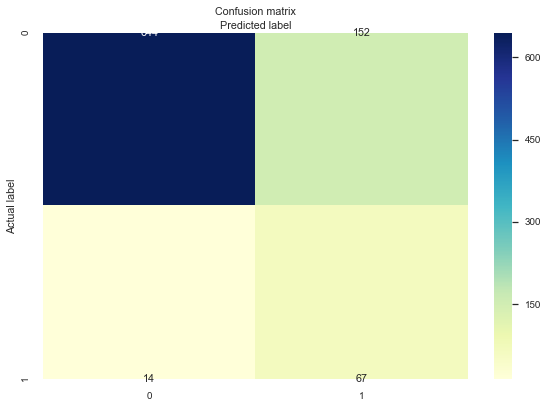

In [287]:
# ????
# default svc with xgb features is the best
best_svc = fit_and_predict(pipeline1,'svc: Best on test', X_train[xgb_features], y_train, X_test[xgb_features], y_test)

In [288]:
baseline_svc_test = fit_and_predict(pipeline1, 'svc: Baseline on test', X_train, y_train, X_test, y_test)

## MODEL SUMMARY

In [289]:
results = model_results.set_index('Name')
pd.set_option('display.max_rows', None)
results = results.sort_values(by=['Roc Auc'],ascending=False)
results

,Accuracy,Recall,Precision,F1,Roc Auc
Name,,,,,
knn: be_features + grid search 300,0.867332,0.833333,0.401460,0.541872,0.852100
rf: Feature importance + random search 1,0.878745,0.803030,0.424000,0.554974,0.844822
svc: xgb_features,0.853067,0.833333,0.374150,0.516432,0.844226
xgb: Feature importance,0.900143,0.772727,0.481132,0.593023,0.843057
rf: Feature importance + random search 2,0.868759,0.803030,0.401515,0.535354,0.839310
xgb: Feature importance + random search 1,0.851641,0.818182,0.369863,0.509434,0.836650
svc: xgb_features + random search 2,0.824536,0.848485,0.331361,0.476596,0.835266
lr: xgb features + grid search 1,0.815977,0.848485,0.320000,0.464730,0.830542
lr: xgb_features,0.815977,0.848485,0.320000,0.464730,0.830542


In [290]:
best_models_names = ['rf: Best on test','xgb: Best on test','lr: Best on test','knn: Best on test','svc: Best on test']
baseline_models_names = ['rf: Baseline on test','xgb: Baseline on test ','lr: Baseline on test','knn: Baseline on test','svc: Baseline on test']
best_baseline_results = results.loc[results.index.intersection(best_models_names+baseline_models_names)]
best_results = results.loc[results.index.intersection(best_models_names)]
best_baseline_results

,Accuracy,Recall,Precision,F1,Roc Auc
lr: Best on test,0.786773,0.864198,0.284553,0.428135,0.821546
xgb: Best on test,0.823261,0.814815,0.320388,0.459930,0.819468
lr: Baseline on test,0.822121,0.814815,0.318841,0.458333,0.818840
svc: Best on test,0.810718,0.827160,0.305936,0.446667,0.818103
svc: Baseline on test,0.851767,0.740741,0.355030,0.480000,0.801903
knn: Best on test,0.833523,0.753086,0.326203,0.455224,0.797397
rf: Best on test,0.841505,0.703704,0.331395,0.450593,0.779616
knn: Baseline on test,0.786773,0.703704,0.259091,0.378738,0.749465
rf: Baseline on test,0.904219,0.395062,0.477612,0.432432,0.675546


rf: Best on test
xgb: Best on test
lr: Best on test
knn: Best on test
svc: Best on test


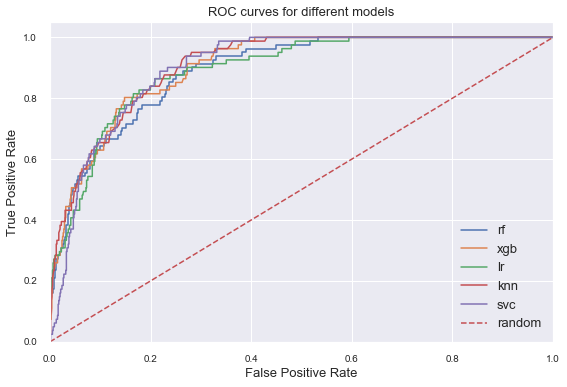

In [291]:
plt.figure()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curves for different models',fontsize=13)
legends = []

for clf,probability in best_clf_probabilities.items():
    print(clf)
    fpr, tpr, thresholds = roc_curve(y_test, probability)
    plt.plot(fpr, tpr)
    legends.append(clf[:-14])

plt.plot([0, 1], [0, 1],'r--')
legends.append('random')
plt.legend(legends,loc="lower right",fontsize=13)
plt.tight_layout()
plt.show()

In [292]:
best_results = best_results.sort_values(by=['Roc Auc'],ascending=False)
best_results

,Accuracy,Recall,Precision,F1,Roc Auc
lr: Best on test,0.786773,0.864198,0.284553,0.428135,0.821546
xgb: Best on test,0.823261,0.814815,0.320388,0.459930,0.819468
svc: Best on test,0.810718,0.827160,0.305936,0.446667,0.818103
knn: Best on test,0.833523,0.753086,0.326203,0.455224,0.797397
rf: Best on test,0.841505,0.703704,0.331395,0.450593,0.779616


In [293]:
best_results = best_results.sort_values(by=['F1'],ascending=False)
best_results

,Accuracy,Recall,Precision,F1,Roc Auc
xgb: Best on test,0.823261,0.814815,0.320388,0.459930,0.819468
knn: Best on test,0.833523,0.753086,0.326203,0.455224,0.797397
rf: Best on test,0.841505,0.703704,0.331395,0.450593,0.779616
svc: Best on test,0.810718,0.827160,0.305936,0.446667,0.818103
lr: Best on test,0.786773,0.864198,0.284553,0.428135,0.821546


In [294]:
best_results = best_results.sort_values(by=['Accuracy'],ascending=False)
best_results

,Accuracy,Recall,Precision,F1,Roc Auc
rf: Best on test,0.841505,0.703704,0.331395,0.450593,0.779616
knn: Best on test,0.833523,0.753086,0.326203,0.455224,0.797397
xgb: Best on test,0.823261,0.814815,0.320388,0.459930,0.819468
svc: Best on test,0.810718,0.827160,0.305936,0.446667,0.818103
lr: Best on test,0.786773,0.864198,0.284553,0.428135,0.821546


In [295]:
best_results = best_results.sort_values(by=['Recall'],ascending=False)
best_results

,Accuracy,Recall,Precision,F1,Roc Auc
lr: Best on test,0.786773,0.864198,0.284553,0.428135,0.821546
svc: Best on test,0.810718,0.827160,0.305936,0.446667,0.818103
xgb: Best on test,0.823261,0.814815,0.320388,0.459930,0.819468
knn: Best on test,0.833523,0.753086,0.326203,0.455224,0.797397
rf: Best on test,0.841505,0.703704,0.331395,0.450593,0.779616


In [296]:
best_results = best_results.sort_values(by=['Precision'],ascending=False)
best_results

,Accuracy,Recall,Precision,F1,Roc Auc
rf: Best on test,0.841505,0.703704,0.331395,0.450593,0.779616
knn: Best on test,0.833523,0.753086,0.326203,0.455224,0.797397
xgb: Best on test,0.823261,0.814815,0.320388,0.459930,0.819468
svc: Best on test,0.810718,0.827160,0.305936,0.446667,0.818103
lr: Best on test,0.786773,0.864198,0.284553,0.428135,0.821546


## Ensemble

In [425]:
##### RUN THIS CELL WILL CLEAR OUT model_results!!!!!!!! #####
model_results = pd.DataFrame(columns=['Name', 'Accuracy', 'Recall', 'Precision', 'F1','Roc Auc'])

In [426]:
# best_models are models that go through: 1. feature selection 2. hyperparameter tuning 
#                                         3. fitted on train and evaluated on val and test

best_models  =  {'Random Forest':[best_rf,rf_features],
                 'XGBoost':[best_xgb,xgb_features],
                 'KNN':[best_knn,be_features],
                 'Logistic Regression':[best_lr,xgb_features],
                 'SVC':[best_svc,xgb_features]}

In [427]:
def results(clf_name, y_val, y_val_pred):
    roc_auc = roc_auc_score(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    add_results(clf_name, accuracy, recall, precision, f1, roc_auc)
 

In [428]:
#Probabilities, predicitons and auc scores of models on the training set and Val sets

#Training set
rf_train_prob = best_rf.predict_proba(X_train[rf_features])
rf_train_pred = best_rf.predict(X_train[rf_features])

knn_train_prob = best_knn.predict_proba(X_train[be_features])
knn_train_pred = best_knn.predict(X_train[be_features])


lr_train_prob = best_lr.predict_proba(X_train[xgb_features])
lr_train_pred = best_lr.predict(X_train[xgb_features])

xgb_train_prob = best_xgb.predict_proba(X_train[xgb_features].values)
xgb_train_pred = best_xgb.predict(X_train[xgb_features].values)

svc_train_prob = best_svc.predict_proba(X_train)
svc_train_pred = best_svc.predict(X_train)

#Validation set
rf_val_prob = best_rf.predict_proba(X_val[rf_features])
rf_val_pred = best_rf.predict(X_val[rf_features])

knn_val_prob = best_knn.predict_proba(X_val[be_features])
knn_val_pred = best_knn.predict(X_val[be_features])

lr_val_prob = best_lr.predict_proba(X_val[xgb_features])
lr_val_pred = best_lr.predict(X_val[xgb_features])

xgb_val_prob = best_xgb.predict_proba(X_val[xgb_features].values)
xgb_val_pred = best_xgb.predict(X_val[xgb_features].values)

svc_val_prob = best_svc.predict_proba(X_val)
svc_val_pred = best_svc.predict(X_val)



#Test set

rf_test_prob = best_rf.predict_proba(X_test[rf_features])
rf_test_pred = best_rf.predict(X_test[rf_features])

knn_test_prob = best_knn.predict_proba(X_test[be_features])
knn_test_pred = best_knn.predict(X_test[be_features])

lr_test_prob = best_lr.predict_proba(X_test[xgb_features])
lr_test_pred = best_lr.predict(X_test[xgb_features])

xgb_test_prob = best_xgb.predict_proba(X_test[xgb_features].values)
xgb_test_pred = best_xgb.predict(X_test[xgb_features].values)

svc_test_prob = best_svc.predict_proba(X_test)
svc_test_pred = best_svc.predict(X_test)


#AUC Scores
rf_roc_auc = roc_auc_score(y_train, rf_train_pred)
knn_roc_auc = roc_auc_score(y_train, knn_train_pred)
svc_roc_auc = roc_auc_score(y_train, svc_train_pred)
lr_roc_auc = roc_auc_score(y_train, lr_train_pred)
xgb_roc_auc = roc_auc_score(y_train, xgb_train_pred)
 


In [429]:
#Dataframes for probabilities of someone being diabetic for Train, Val and Test sets from all the different models

df_train_prob = pd.DataFrame(columns = ["rf", "knn", "svc", "lr", "xgb"], index= X_train.index)
for i in range(len(X_train)):
    df_train_prob["rf"].iloc[i] = rf_train_prob[i][1]
    df_train_prob["knn"].iloc[i] = knn_train_prob[i][1]
    df_train_prob["svc"].iloc[i] = svc_train_prob[i][1]
    df_train_prob["lr"].iloc[i] = lr_train_prob[i][1]
    df_train_prob["xgb"].iloc[i] = xgb_train_prob[i][1]
#print("Train Probabilities")
#print(df_train_prob)

df_val_prob = pd.DataFrame(columns = ["rf", "knn", "svc", "lr", "xgb"], index= X_val.index)
for i in range(len(X_val)):
    df_val_prob["rf"].iloc[i] = rf_val_prob[i][1]
    df_val_prob["knn"].iloc[i] = knn_val_prob[i][1]
    df_val_prob["svc"].iloc[i] = svc_val_prob[i][1]
    df_val_prob["lr"].iloc[i] = lr_val_prob[i][1]
    df_val_prob["xgb"].iloc[i] = xgb_val_prob[i][1]
#print("Val Probabilities")
#print(df_val_prob)


df_test_prob = pd.DataFrame(columns = ["rf", "knn", "svc", "lr", "xgb"], index= X_test.index)
for i in range(len(X_test)):
    df_test_prob["rf"].iloc[i] = rf_test_prob[i][1]
    df_test_prob["knn"].iloc[i] = knn_test_prob[i][1]
    df_test_prob["svc"].iloc[i] = svc_test_prob[i][1]
    df_test_prob["lr"].iloc[i] = lr_test_prob[i][1]
    df_test_prob["xgb"].iloc[i] = xgb_test_prob[i][1]
#print("Test Probabilities")
#print(df_test_prob)


#Dataframes for predictions of someone being diabetic for Train and Val sets from all different models
df_train_pred = pd.DataFrame(columns = ["rf", "knn", "svc", "lr", "xgb", "True"], index= X_train.index)
for i in range(len(X_train)):
    df_train_pred["rf"].iloc[i] = rf_train_pred[i]
    df_train_pred["knn"].iloc[i] = knn_train_pred[i]
    df_train_pred["svc"].iloc[i] = svc_train_pred[i]
    df_train_pred["lr"].iloc[i] = lr_train_pred[i]
    df_train_pred["xgb"].iloc[i] = xgb_train_pred[i]
    df_train_pred["True"].iloc[i] = y_train.iloc[i]
#print("Train Predictions")
#print(df_train_pred)

df_val_pred = pd.DataFrame(columns = ["rf", "knn", "svc", "lr", "xgb", "True"], index= X_val.index)
for i in range(len(X_val)):
    df_val_pred["rf"].iloc[i] = rf_val_pred[i]
    df_val_pred["knn"].iloc[i] = knn_val_pred[i]
    df_val_pred["svc"].iloc[i] = svc_val_pred[i]
    df_val_pred["lr"].iloc[i] = lr_val_pred[i]
    df_val_pred["xgb"].iloc[i] = xgb_val_pred[i]
    df_val_pred["True"].iloc[i] = y_val.iloc[i]
#print("Val Predictions")
#print(df_val_pred)



df_test_pred = pd.DataFrame(columns = ["rf", "knn", "svc", "lr", "xgb", "True"], index= X_test.index)
for i in range(len(X_test)):
    df_test_pred["rf"].iloc[i] = rf_test_pred[i]
    df_test_pred["knn"].iloc[i] = knn_test_pred[i]
    df_test_pred["svc"].iloc[i] = svc_test_pred[i]
    df_test_pred["lr"].iloc[i] = lr_test_pred[i]
    df_test_pred["xgb"].iloc[i] = xgb_test_pred[i]
    df_test_pred["True"].iloc[i] = y_test.iloc[i]

#print("Test Predictions")
#print(df_test_pred)


In [430]:
#Test, Train and Val sets containing predicitons (Features are individual predictions of 5 different models)
X_train_ensemble = df_train_pred.loc[:, df_train_pred.columns != 'True']
y_train_ensemble = df_train_pred.loc[:, df_train_pred.columns == 'True']

X_test_ensemble = df_test_pred.loc[:, df_test_pred.columns != 'True']
y_test_ensemble = df_test_pred.loc[:, df_test_pred.columns == 'True']

X_val_ensemble = df_val_pred.loc[:, df_val_pred.columns != 'True']
y_val_ensemble = df_val_pred.loc[:, df_val_pred.columns == 'True']



### Simple Average

Averages predicted probabilities of individual models to obtain the final probability.
A threshold of p = 0.5 was used to determine if a person is diabetic or not
https://arxiv.org/pdf/1708.07480.pdf

In [431]:
#Ensemble model and predictions on the training set
ensemble_train_prob1 = (rf_train_prob + knn_train_prob + svc_train_prob + lr_train_prob + xgb_train_prob)/5

ensemble_train_pred1 = []
for i in ensemble_train_prob1:
    if i[1] > 0.5:          #i[0] = Prob(Not diabetic) ; i[1] = Prob(Diabetic)
        value = 1
    else:
        value = 0
    ensemble_train_pred1.append(value)


#results("Simple average on Train", y_train_ensemble, ensemble_train_pred1)


#Ensemble model and predictions on the Validation set
ensemble_val_prob1 = (rf_val_prob + knn_val_prob + svc_val_prob + lr_val_prob + xgb_val_prob)/5

ensemble_val_pred1 = []
for i in ensemble_val_prob1:
    if i[1] > 0.5:
        value = 1
    else:
        value = 0
    ensemble_val_pred1.append(value)

results("Simple average on Val", y_val_ensemble, ensemble_val_pred1)


#Ensemble model and predictions on the test set
ensemble_test_prob1 = (rf_test_prob + knn_test_prob + svc_test_prob + lr_test_prob + xgb_test_prob)/5

ensemble_test_pred1 = []
for i in ensemble_test_prob1:
    if i[1] > 0.5:          #i[0] = Prob(Not diabetic) ; i[1] = Prob(Diabetic)
        value = 1
    else:
        value = 0
    ensemble_test_pred1.append(value)
results("Simple average on Test", y_test_ensemble, ensemble_test_pred1)

### AUC weighted

Probabilities are a weighted average of AUC scores. A threshold of p = 0.5 was used to determine if a person is diabetic or not
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6836338/pdf/12911_2019_Article_918.pdf

In [432]:
#AUC weights
rf_weight = rf_roc_auc / (rf_roc_auc + knn_roc_auc + svc_roc_auc + lr_roc_auc + xgb_roc_auc)
knn_weight = knn_roc_auc / (rf_roc_auc + knn_roc_auc + svc_roc_auc + lr_roc_auc + xgb_roc_auc)
svc_weight = svc_roc_auc / (rf_roc_auc + knn_roc_auc + svc_roc_auc + lr_roc_auc + xgb_roc_auc)
lr_weight = lr_roc_auc / (rf_roc_auc + knn_roc_auc + svc_roc_auc + lr_roc_auc + xgb_roc_auc)
xgb_weight = xgb_roc_auc / (rf_roc_auc + knn_roc_auc + svc_roc_auc + lr_roc_auc + xgb_roc_auc)

#Ensemble model and predictions on the training set
ensemble_train_prob2 = (rf_weight*rf_train_prob) + (knn_train_prob*knn_weight) + (svc_train_prob*svc_weight) + (lr_train_prob*lr_weight) + (xgb_train_prob*xgb_weight)

ensemble_train_pred2 = []
for i in ensemble_train_prob2:
    if i[1] > 0.5:
        value = 1
    else:
        value = 0
    ensemble_train_pred2.append(value)
#results("AUC weighted on Train",y_train_ensemble, ensemble_train_pred2)

#Ensemble model and predictions on the Validation set
ensemble_val_prob2 = (rf_weight*rf_val_prob) + (knn_val_prob*knn_weight) + (svc_val_prob*svc_weight) + (lr_val_prob*lr_weight) + (xgb_val_prob*xgb_weight)

ensemble_val_pred2 = []
for i in ensemble_val_prob2:
    if i[1] > 0.5:
        value = 1
    else:
        value = 0
    ensemble_val_pred2.append(value)
results("AUC weighted on Val",y_val, ensemble_val_pred2)


#Ensemble model and predictions on the test set
ensemble_test_prob2 = (rf_weight*rf_test_prob) + (knn_test_prob*knn_weight) + (svc_test_prob*svc_weight) + (lr_test_prob*lr_weight) + (xgb_test_prob*xgb_weight)

ensemble_test_pred2 = []
for i in ensemble_test_prob2:
    if i[1] > 0.5:
        value = 1
    else:
        value = 0
    ensemble_test_pred2.append(value)
results("AUC weighted on Test",y_test_ensemble, ensemble_test_pred2)


### Majority Voting

Since 5 models are chosen to build the ensemble model, if more than 3 out of 5 models predict that a subject is diabetic, then the final ensemble model also predicts that the subject is diabetic
https://www.ijrte.org/wp-content/uploads/papers/v7i6s4/F10390476S419.pdf

In [433]:
#Training set
sum_train_pred = rf_train_pred + svc_train_pred + knn_train_pred + lr_train_pred + xgb_train_pred
#print(sum_train_pred)

ensemble_train_pred3 = []

for i in range(len(X_train)):
    if sum_train_pred[i] > 2:
        value = 1
    else:
        value = 0
    ensemble_train_pred3.append(value)
#results("Majority voting on Train",y_train_ensemble, ensemble_train_pred3)


#Val set
sum_val_pred = rf_val_pred + svc_val_pred + knn_val_pred + lr_val_pred + xgb_val_pred

ensemble_val_pred3 = []

for i in range(len(X_val)):
    if sum_val_pred[i] > 2:
        value = 1
    else:
        value = 0
    ensemble_val_pred3.append(value)
results("Majority voting on Val",y_val, ensemble_val_pred3)


#Test set
sum_test_pred = rf_test_pred + svc_test_pred + knn_test_pred + lr_test_pred + xgb_test_pred
#print(sum_test_pred)

ensemble_test_pred3 = []

for i in range(len(X_test)):
    if sum_test_pred[i] > 2:
        value = 1
    else:
        value = 0
    ensemble_test_pred3.append(value)
results("Majority voting on Test",y_test_ensemble, ensemble_test_pred3)  


### RF built using predicitons from RF, SVC, LR, XGB and KNN

Binary predicitons from the 5 different models are used as features and Random Forest was build to predict the True outcome (of diabetic or not) using these 5 features. Model was built on the Validation set and used to predict on the test set.

In [434]:
#Random Forest on predictions from RF, SVC, LR, XGB, KNN
rf_ensemble = RandomForestClassifier(random_state = 42, criterion= 'gini')
rf_ensemble = rf_ensemble.fit(X_val_ensemble, y_val_ensemble)
ensemble_val_pred4 = rf_ensemble.predict(X_val_ensemble)
results("RF ensemble on Val",y_val_ensemble, ensemble_val_pred4)  

ensemble_test_pred4 = rf_ensemble.predict(X_test_ensemble)
results("RF ensemble on Test",y_test_ensemble, ensemble_test_pred4)  

#Logistic Regression on predictions from RF, SVC, LR, XGB, KNN
logreg = LogisticRegression()
logreg = logreg.fit(X_val_ensemble, y_val_ensemble)
ensemble_val_pred5 = logreg.predict(X_val_ensemble)
results("LR (on prob) on Val",y_val_ensemble, ensemble_val_pred5)  

ensemble_test_pred5 = logreg.predict(X_test_ensemble)
results("LR (on prob) on Test",y_test_ensemble, ensemble_test_pred5)  

In [435]:
print(model_results)

                      Name  Accuracy    Recall  Precision        F1   Roc Auc
0     AUC weighted on Test  0.857469  0.802469   0.373563  0.509804  0.832767
1      AUC weighted on Val  0.877318  0.833333   0.423077  0.561224  0.857612
2  Majority voting on Test  0.838084  0.814815   0.341969  0.481752  0.827634
3   Majority voting on Val  0.865906  0.833333   0.398551  0.539216  0.851312
7      RF ensemble on Test  0.882554  0.629630   0.411290  0.497561  0.768961
4       RF ensemble on Val  0.910128  0.727273   0.516129  0.603774  0.828203
5   Simple average on Test  0.855188  0.802469   0.369318  0.505837  0.831511
6    Simple average on Val  0.877318  0.833333   0.423077  0.561224  0.857612
